In [3]:
# Built-in modules
import os
import glob
import json
from typing import Tuple, List
from datetime import datetime, timedelta
import pickle
import shutil
import warnings
warnings.filterwarnings('ignore')

# Basics of Python data handling and visualization
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm

# Data reding for training validation purposes:
# from utils.data_transform import PlanetTransform, Sentinel1Transform, Sentinel2Transform
from utils.planet_reader import PlanetReader
# from utils.sentinel_1_reader import S1Reader
from utils.sentinel_2_reader import S2Reader
from utils.data_loader import DataLoader
# from utils.baseline_models import SpatiotemporalModel
# from utils import train_valid_eval_utils as tveu
# from utils import unzipper
# from torch.optim import Adam
# from torch.optim import SGD
# from torch.nn import CrossEntropyLoss
# from torch.nn import NLLLoss
# import torch
# from torch.utils.tensorboard import SummaryWriter
# from sklearn.metrics import confusion_matrix

In [4]:
#CREATE THE FOLDER FOR THE DATA TO BE DOWNLOADED AND SET DOWNLOAD CREDENTIALS

from radiant_mlhub import Dataset

os.environ['MLHUB_API_KEY'] = '380ab1acf08f82cddc417ddaf61b6acbaceb0e6a125435e63b79d93efe0110c6'

if not os.path.exists('data/'):
    os.makedirs('data/')

In [5]:
# Download the Brandenburg-Germany Dataset
dataset = Dataset.fetch('dlr_fusion_competition_germany')
print(f'{dataset.id}: {dataset.title}')
dataset.download('data/')

dlr_fusion_competition_germany: A Fusion Dataset for Crop Type Classification in Germany


INFO:radiant_mlhub.client.catalog_downloader:unarchive dlr_fusion_competition_germany.tar.gz ...
unarchive dlr_fusion_competition_germany.tar.gz: 100%|██████████| 1790/1790 [00:00<00:00, 24682.27it/s]
INFO:radiant_mlhub.client.catalog_downloader:create stac asset list (please wait) ...
INFO:radiant_mlhub.client.catalog_downloader:1654 unique assets in stac catalog.
download assets: 100%|██████████| 1654/1654 [00:05<00:00, 303.46it/s]
INFO:radiant_mlhub.client.catalog_downloader:assets saved to data\dlr_fusion_competition_germany


In [6]:
brandenburg_tr_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/vector_labels.geojson'
brandenburg_te_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_test_labels/dlr_fusion_competition_germany_test_labels_33N_17E_243N/vector_labels.geojson'

In [7]:
brandenburg_tr_labels=gpd.read_file(brandenburg_tr_labels_dir)
print('INFO: Number of fields: {}\n'.format(len(brandenburg_tr_labels)))
brandenburg_tr_labels.info()
brandenburg_tr_labels.tail()

INFO: Number of fields: 2534

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         2534 non-null   int64   
 1   SHAPE_AREA  2534 non-null   float64 
 2   SHAPE_LEN   2534 non-null   float64 
 3   crop_id     2534 non-null   int64   
 4   crop_name   2534 non-null   object  
 5   geometry    2534 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 118.9+ KB


,fid,SHAPE_AREA,SHAPE_LEN,crop_id,crop_name,geometry
2529,210145,259644.80075,2922.908013,5,Corn,"MULTIPOLYGON (((451162.920 5809950.180, 451386..."
2530,210149,11260.80940,433.843678,2,Rye,"MULTIPOLYGON (((452645.460 5809120.610, 452645..."
2531,210174,593211.62605,3766.251880,5,Corn,"MULTIPOLYGON (((451948.160 5827166.390, 451948..."
2532,210179,48034.13890,1210.785843,9,Forage Crops,"MULTIPOLYGON (((439830.770 5808003.000, 439881..."
2533,210180,428209.99690,3885.101917,6,Oil Seeds,"MULTIPOLYGON (((437976.290 5828007.960, 437952..."


In [8]:
brandenburg_te_labels=gpd.read_file(brandenburg_te_labels_dir)
print('INFO: Number of fields: {}\n'.format(len(brandenburg_te_labels)))
brandenburg_te_labels.info()
brandenburg_te_labels.tail()


INFO: Number of fields: 2064

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2064 entries, 0 to 2063
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         2064 non-null   int64   
 1   SHAPE_AREA  2064 non-null   float64 
 2   SHAPE_LEN   2064 non-null   float64 
 3   crop_id     2064 non-null   int64   
 4   crop_name   2064 non-null   object  
 5   geometry    2064 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 96.9+ KB


,fid,SHAPE_AREA,SHAPE_LEN,crop_id,crop_name,geometry
2059,211781,53043.495269,1293.383835,9,Forage Crops,"MULTIPOLYGON (((422780.790 5847737.560, 422759..."
2060,211917,39686.602456,921.331461,6,Oil Seeds,"MULTIPOLYGON (((423316.480 5847950.820, 423323..."
2061,211995,4248.183887,356.275619,8,Meadows,"MULTIPOLYGON (((428263.130 5853521.381, 428213..."
2062,211997,32367.320191,768.085690,8,Meadows,"MULTIPOLYGON (((428123.080 5853365.400, 428119..."
2063,212315,4593.800455,287.130172,9,Forage Crops,"MULTIPOLYGON (((429146.640 5847412.550, 429147..."


In [9]:
label_ids=brandenburg_tr_labels['crop_id'].unique()
label_names=brandenburg_tr_labels['crop_name'].unique()

print('INFO: Label IDs: {}'.format(label_ids))
print('INFO: Label Names: {}'.format(label_names))

INFO: Label IDs: [9 1 8 2 3 5 6 7 4]
INFO: Label Names: ['Forage Crops' 'Wheat' 'Meadows' 'Rye' 'Barley' 'Corn' 'Oil Seeds'
 'Root Crops' 'Oats']


INFO: Number of Fields by Crop Type: 
Meadows         954
Forage Crops    339
Wheat           305
Rye             279
Corn            251
Oil Seeds       201
Barley          137
Oats             45
Root Crops       23
Name: crop_name, dtype: int64


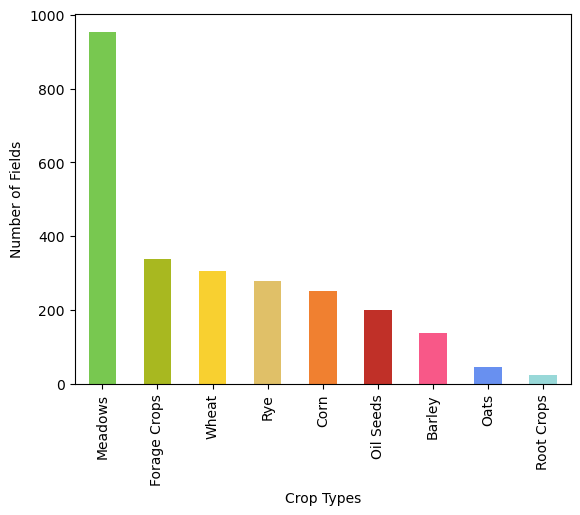

In [10]:
value_counts=brandenburg_tr_labels['crop_name'].value_counts()

colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 
ax=value_counts.plot.bar(color=colors_list)
ax.set_ylabel("Number of Fields")
ax.set_xlabel("Crop Types")

print('INFO: Number of Fields by Crop Type: \n{}'.format(value_counts))

# Working with Sentinel 2 Data

In [11]:
brandenburg_s2_train_dir = "data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/"
brandenburg_tr_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/vector_labels.geojson'

In [12]:
#INITIALIZE THE DATA READER TO OBSERVE THE FIELDS FROM PLANET DATA: 

# Choose some days of the year to plot
selected_data_indices = [10,20,30,40,50] #beware that S2 data is not daily, 

#Initialize data reader for planet images
s2_reader = S2Reader(input_dir=brandenburg_s2_train_dir, label_dir=brandenburg_tr_labels_dir, selected_time_points=selected_data_indices)

INFO: Ignoring 30/2534 fields with area < 1000m2


INFO: Extracting time series into the folder: data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/: 100%|██████████| 2504/2504 [00:00<00:00, 7397.21it/s]


In [13]:
def true_color(X):
    blue = X[1]/(X[1].max()/255.0)
    green = X[2]/(X[2].max()/255.0)
    red = X[3]/(X[3].max()/255.0)
    tc = np.dstack((red,green,blue)) 
    
    return tc.astype('uint8')

def ndvi(X):
    red = X[3]
    nir = X[7]
    return (nir-red) / (nir + red)

  0%|          | 0/9 [00:00<?, ?it/s]

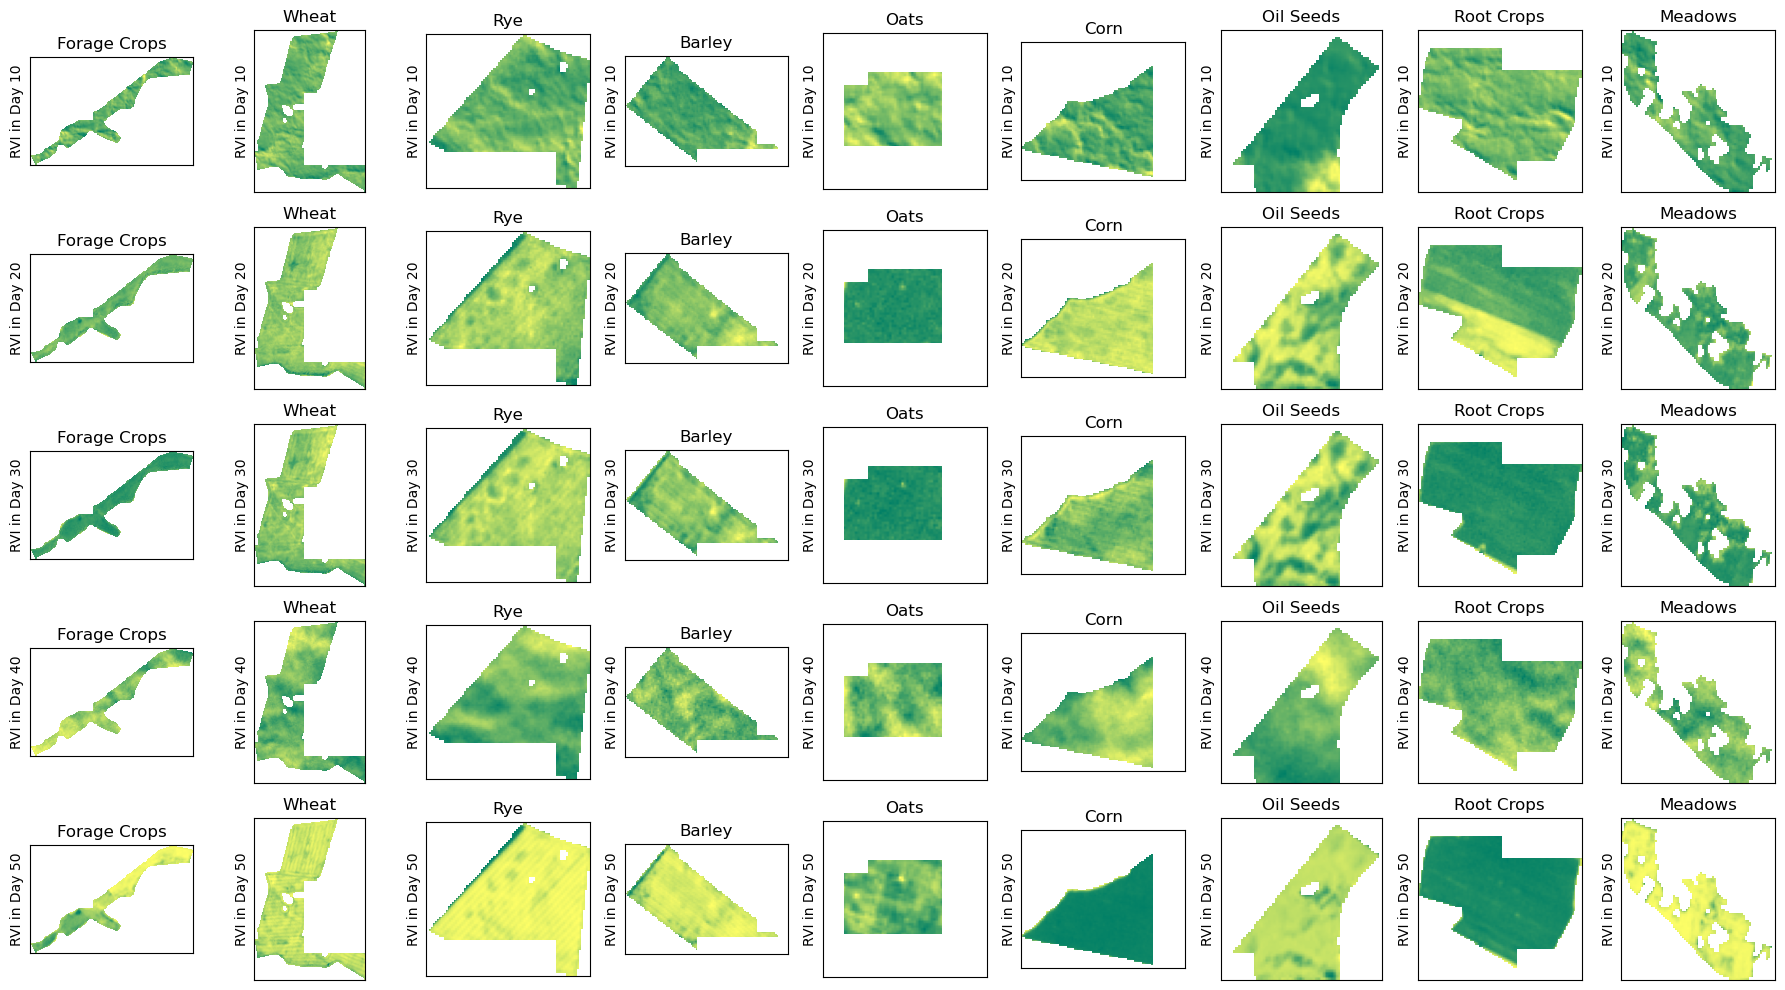

In [15]:
num_row = len(selected_data_indices)
num_col = len(label_ids)
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))

pbar = tqdm(total=len(label_ids))
iterable=iter(s2_reader)
for crop_id, crop_name in zip(label_ids,label_names):
    while True:
        # read a field sample
        X,y,mask,_ = next(iterable) 
        
        width=X.shape[-1]
        height=X.shape[-2]
        
        #Get one sample for each crop type, and
        #consider large areas (at least 60x60) to display
        if y == crop_id and width>60 and height>60:
            for i, day in enumerate(selected_data_indices):
                 
                # Display RVI index of the field in a given day for a given crop type
                ax = axes[i%num_row, crop_id%num_col]
                ax.title.set_text('{}'.format(crop_name))
                ax.set_ylabel('RVI in Day {}'.format(day))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(ndvi(X[i]*mask),cmap=plt.cm.summer)
                
            #if one sample selected for a crop type, break the WHILE loop
            pbar.set_description("Plotting {} Fields".format(crop_name))
            pbar.update(1)
            break
        
        
plt.tight_layout()
plt.show()
pbar.set_description("Plotting Complete!")
pbar.close()
